## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

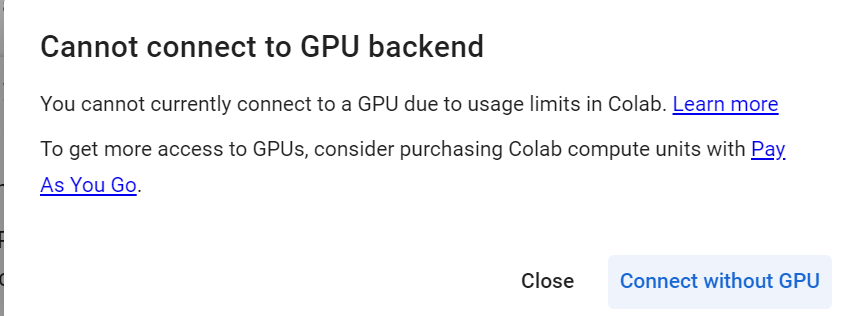

## **Installing and Importing Necessary Libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
# Installing required libraries
!pip install -U sentence-transformers==4.0.2 gensim==4.3.3 transformers==4.50.3 tqdm==4.67.1 scikit-learn==1.6.1 pandas==2.2.2 numpy==2.0.0 matplotlib==3.9.4 seaborn==0.13.2 -q
!pip install --upgrade numpy gensim

ERROR: Cannot install gensim==4.3.3 and numpy==2.0.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


## **Loading the dataset**

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
from transformers import pipeline
import nltk


# Load dataset
stock_news = pd.read_csv("stock_news.csv")
stock = stock_news.copy()


## **Data Overview**

In [3]:
# Data Overview
print(stock.head())
# To check the shape of the data
print(stock.shape)
print(stock.dtypes)
# To convert the 'Date' column in the 'stock' DataFrame to datetime format.
stock['Date'] = pd.to_datetime(stock['Date'])
# To check the statistical summary
print(stock.describe())
# Check the duplicate values
print(stock.duplicated().sum())
print(stock.isnull().sum())

         Date                                               News       Open  \
0  2019-01-02   The tech sector experienced a significant dec...  41.740002   
1  2019-01-02   Apple lowered its fiscal Q1 revenue guidance ...  41.740002   
2  2019-01-02   Apple cut its fiscal first quarter revenue fo...  41.740002   
3  2019-01-02   This news article reports that yields on long...  41.740002   
4  2019-01-02   Apple's revenue warning led to a decline in U...  41.740002   

        High        Low      Close     Volume  Label  
0  42.244999  41.482498  40.246914  130672400     -1  
1  42.244999  41.482498  40.246914  130672400     -1  
2  42.244999  41.482498  40.246914  130672400     -1  
3  42.244999  41.482498  40.246914  130672400     -1  
4  42.244999  41.482498  40.246914  130672400     -1  
(349, 8)
Date       object
News       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Label       int64
dtype: object
                            

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

## **Data Preprocessing**

In [4]:
# Checking for missing and duplicate values
print("Missing values:\n", stock.isnull().sum())
print("Duplicate rows:", stock.duplicated().sum())


Missing values:
 Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64
Duplicate rows: 0


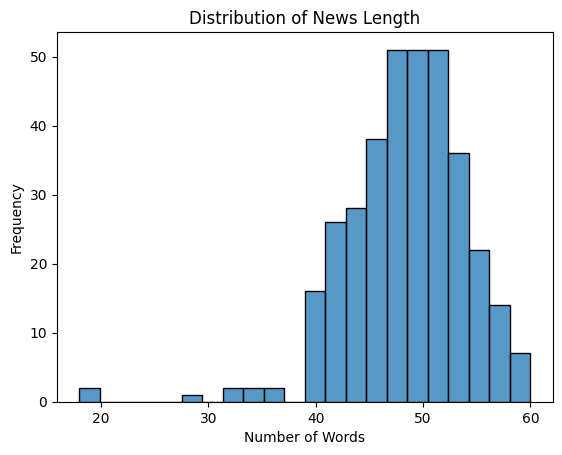

In [5]:
# Univariate Analysis: Distribution of news length
stock['news_len'] = stock['News'].apply(lambda x: len(x.split()))
sns.histplot(stock['news_len'])
plt.title("Distribution of News Length")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

Most news articles have between 40–55 words, suggesting consistent formatting (possibly headlines or short briefs).

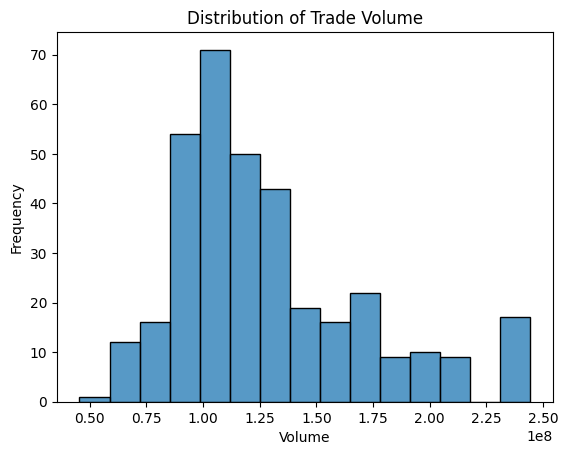

In [6]:
# Univariate Analysis: Volume
sns.histplot(stock['Volume'])
plt.title("Distribution of Trade Volume")
plt.xlabel("Volume")
plt.ylabel("Frequency")
plt.show()

The distribution is right-skewed, with a majority of trade volumes clustered.

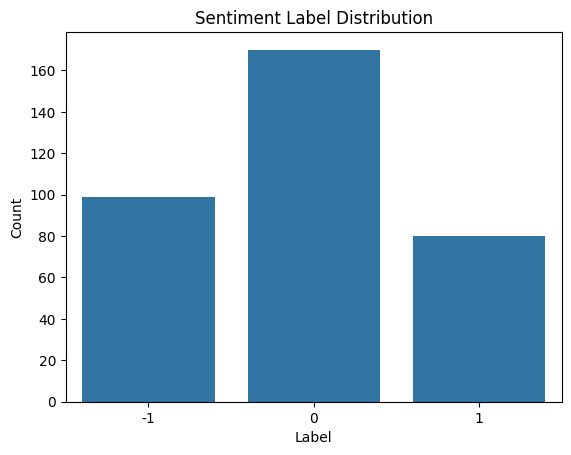

In [7]:
# Label Distribution
sns.countplot(data=stock, x='Label')
plt.title("Sentiment Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


The data is imbalanced, with neutral sentiment dominating, followed by negative and positive.

Bivariate Analysis

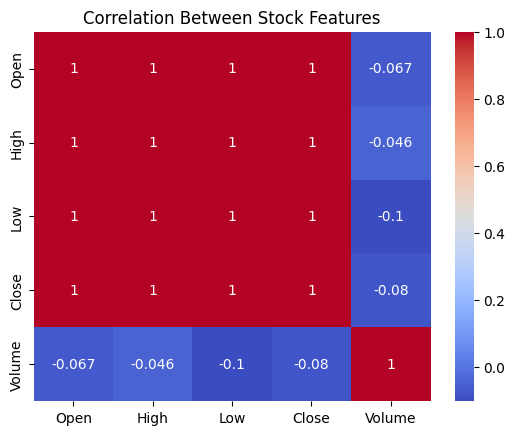

In [8]:
# Correlation heatmap
sns.heatmap(stock[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Stock Features")
plt.show()


Open, High, Low, and Close are highly correlated (as expected), while Volume shows weak correlation with all price points.

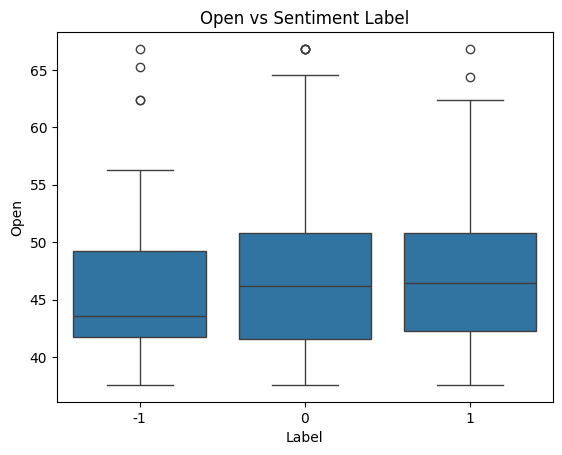

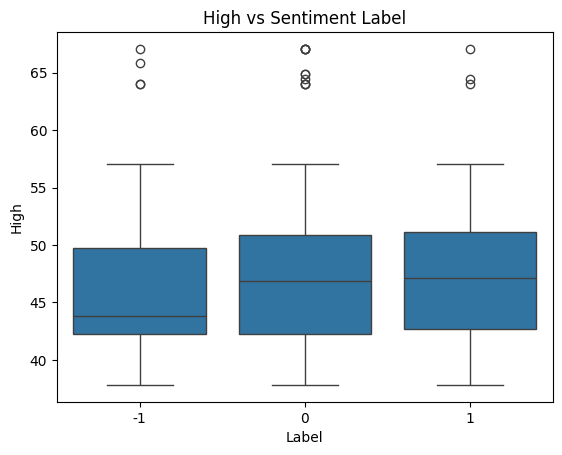

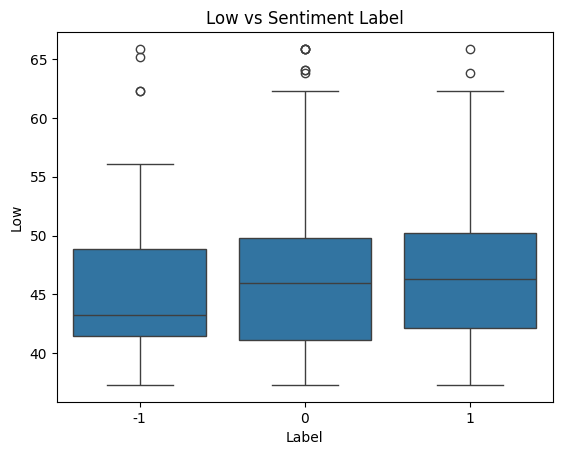

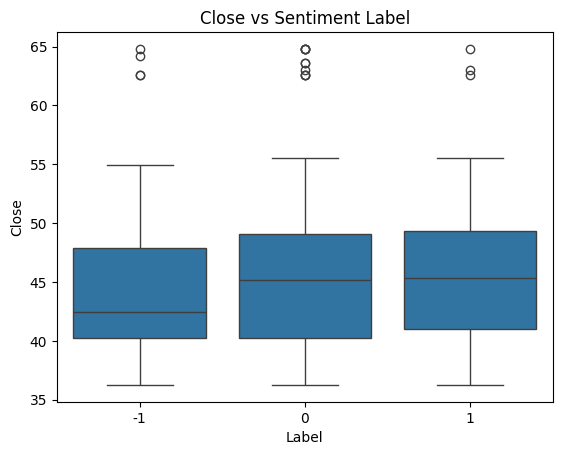

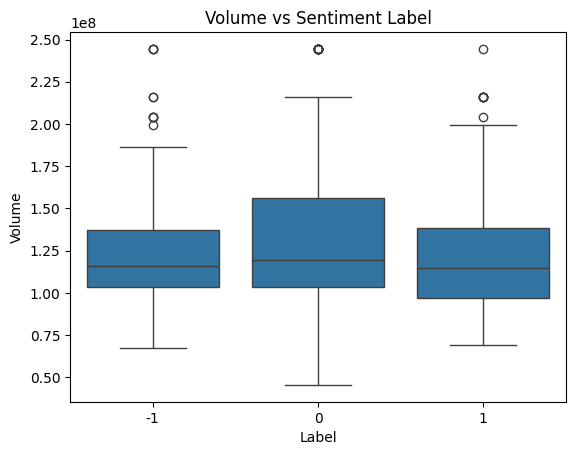

In [9]:
# Sentiment Polarity vs Price (Boxplots)
for feature in ['Open', 'High', 'Low', 'Close']:
    sns.boxplot(data=stock, x='Label', y=feature)
    plt.title(f"{feature} vs Sentiment Label")
    plt.show()
# Sentiment Polarity vs Volume
sns.boxplot(data=stock, x='Label', y='Volume')
plt.title("Volume vs Sentiment Label")
plt.show()


- Stock prices (Open, High, Low, Close) show a slight upward shift in the positive sentiment class, but the distributions are overlapping.
- Volume is higher for neutral news, lower for negative and positive. This may imply speculative trading happens more in the absence of polarizing news.

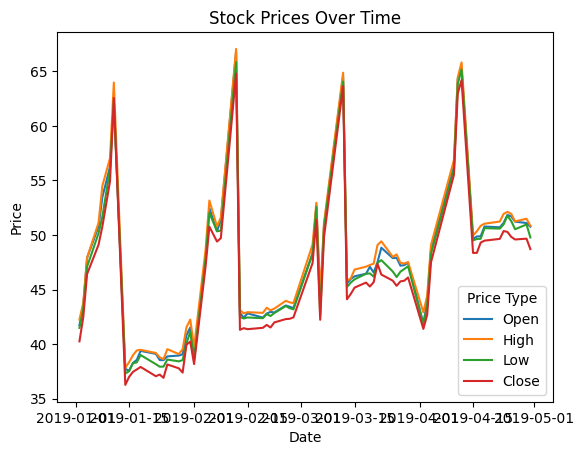

In [10]:
# Date vs Price
stock_daily = stock.groupby('Date').agg({'Open':'mean','High':'mean','Low':'mean','Close':'mean','Volume':'mean'}).reset_index()
df_melted = stock_daily.drop("Volume", axis=1).melt(id_vars='Date', var_name='Price Type', value_name='Price')
sns.lineplot(data=df_melted, x='Date', y='Price', hue='Price Type')
plt.title('Stock Prices Over Time')
sns.set_theme(rc={'figure.figsize':(15,15)})
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


A gradual upward trend is seen in stock prices over time, with occasional dips.

In [11]:
# Train-validation-test split
X_train = stock[(stock['Date'] < '2019-04-01')].reset_index()
X_val = stock[(stock['Date'] >= '2019-04-01') & (stock['Date'] < '2019-04-16')].reset_index()
X_test = stock[stock['Date'] >= '2019-04-16'].reset_index()

In [12]:
y_train = X_train['Label'].copy()
y_val = X_val['Label'].copy()
y_test = X_test['Label'].copy()

In [13]:
print("Train data:", X_train.shape)
print("Validation data:", X_val.shape)
print("Test data:", X_test.shape)

Train data: (286, 10)
Validation data: (21, 10)
Test data: (42, 10)


## **Word Embeddings**

In [14]:
# Prepare corpus for embedding
words_list = [item.split(" ") for item in stock['News'].values]

In [15]:
# Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size=vec_size, min_count=1, window=5, workers=4)
word_vector_dict = {word: model_W2V.wv[word] for word in model_W2V.wv.index_to_key}


In [16]:
# Average vectorizer for Word2Vec
def average_vectorizer_Word2Vec(doc):
    feature_vector = np.zeros((vec_size,), dtype="float64")
    words_in_vocab = [word for word in doc.split() if word in word_vector_dict]
    for word in words_in_vocab:
        feature_vector += word_vector_dict[word]
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)
    return feature_vector


In [17]:
# Transform datasets
start = time.time()
X_train_wv = pd.DataFrame(X_train['News'].apply(average_vectorizer_Word2Vec).tolist())
X_val_wv = pd.DataFrame(X_val['News'].apply(average_vectorizer_Word2Vec).tolist())
X_test_wv = pd.DataFrame(X_test['News'].apply(average_vectorizer_Word2Vec).tolist())
end = time.time()
print("Word2Vec transformation done in", end - start, "seconds")


Word2Vec transformation done in 0.09289193153381348 seconds


In [18]:
# GloVe
glove_model = KeyedVectors.load_word2vec_format('glove.6B.100d.txt.word2vec', binary=False)
glove_words = glove_model.index_to_key
glove_word_vector_dict = dict(zip(glove_words, list(glove_model.vectors)))
vec_size_glove = 100

def average_vectorizer_GloVe(doc):
    feature_vector = np.zeros((vec_size_glove,), dtype="float64")
    words_in_vocab = [word for word in doc.split() if word in glove_word_vector_dict]
    for word in words_in_vocab:
        feature_vector += glove_word_vector_dict[word]
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)
    return feature_vector



In [19]:
# Transform datasets using GloVe
start = time.time()
X_train_gl = pd.DataFrame(X_train['News'].apply(average_vectorizer_GloVe).tolist())
X_val_gl = pd.DataFrame(X_val['News'].apply(average_vectorizer_GloVe).tolist())
X_test_gl = pd.DataFrame(X_test['News'].apply(average_vectorizer_GloVe).tolist())
end = time.time()
print("GloVe transformation done in", end - start, "seconds")


GloVe transformation done in 0.04496192932128906 seconds


In [20]:
# Sentence Transformer
model_st = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [21]:
start = time.time()
X_train_st = model_st.encode(X_train['News'].values, show_progress_bar=True, device=device)
X_val_st = model_st.encode(X_val['News'].values, show_progress_bar=True, device=device)
X_test_st = model_st.encode(X_test['News'].values, show_progress_bar=True, device=device)
end = time.time()
print("SentenceTransformer encoding done in", end - start, "seconds")


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

SentenceTransformer encoding done in 12.445342063903809 seconds


## **Sentiment Analysis**

In [22]:
# Utility function for model performance

def model_performance(model, X, y):
    pred = model.predict(X)
    return {
        'Accuracy': accuracy_score(y, pred),
        'Recall': recall_score(y, pred, average='weighted'),
        'Precision': precision_score(y, pred, average='weighted'),
        'F1 Score': f1_score(y, pred, average='weighted')
    }

def plot_conf_matrix(model, X, y, title):
    pred = model.predict(X)
    cm = confusion_matrix(y, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()





## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [23]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used

!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1
!pip install llama-cpp-python -q

In [24]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

Word2Vec - Train Performance {'Accuracy': 1.0, 'Recall': 1.0, 'Precision': 1.0, 'F1 Score': 1.0}
Word2Vec - Validation Performance {'Accuracy': 0.38095238095238093, 'Recall': 0.38095238095238093, 'Precision': 0.2689075630252101, 'F1 Score': 0.31527093596059114}


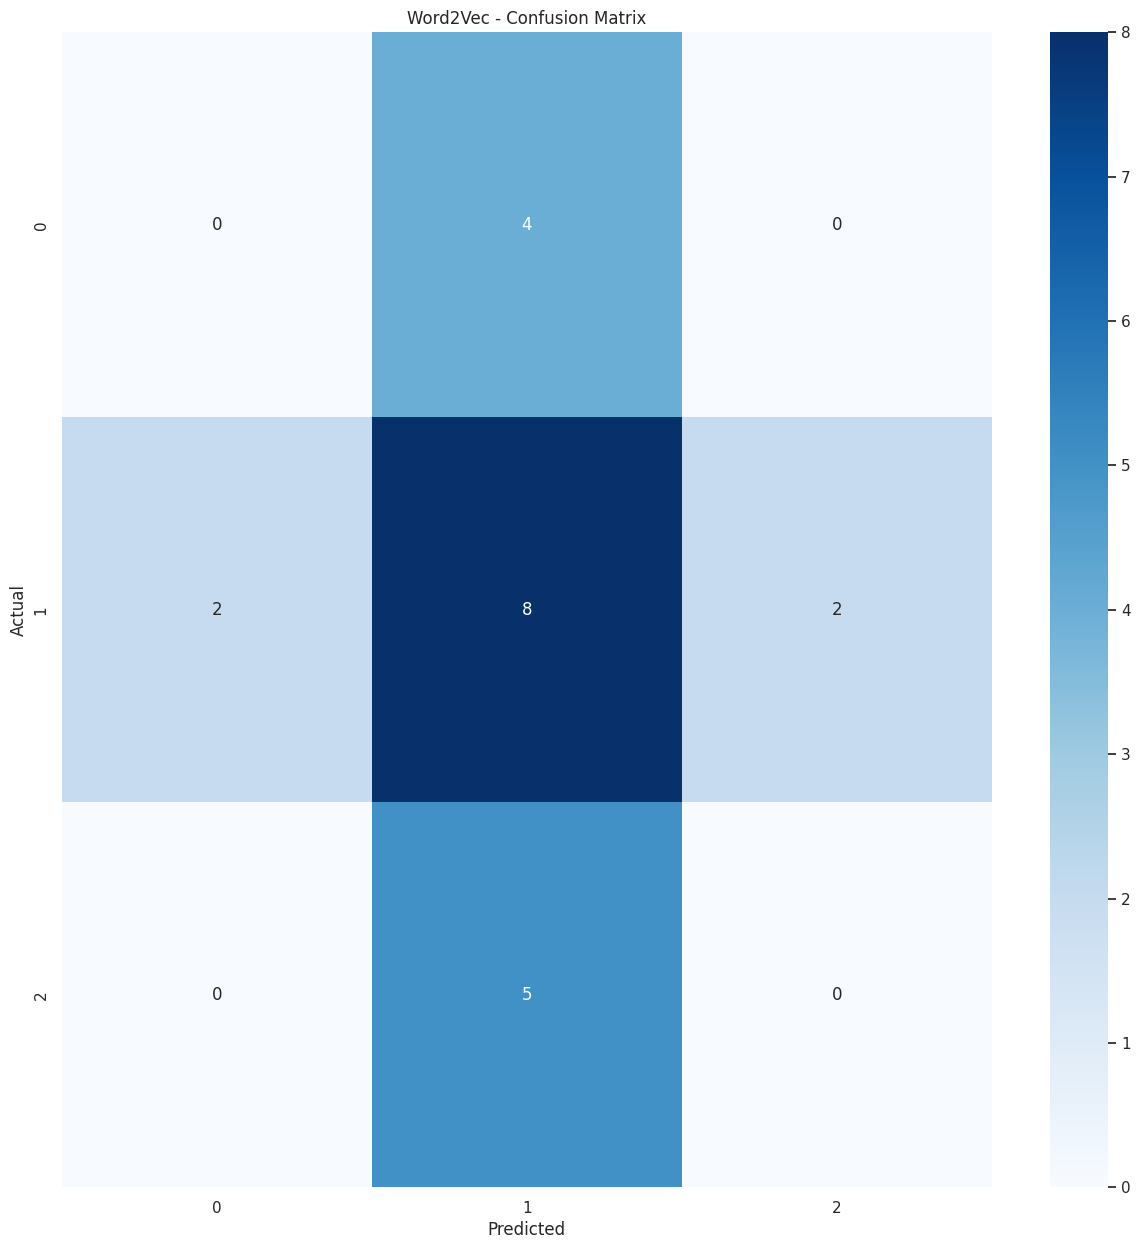

GloVe - Train Performance {'Accuracy': 1.0, 'Recall': 1.0, 'Precision': 1.0, 'F1 Score': 1.0}
GloVe - Validation Performance {'Accuracy': 0.47619047619047616, 'Recall': 0.47619047619047616, 'Precision': 0.40079365079365076, 'F1 Score': 0.42687074829931976}


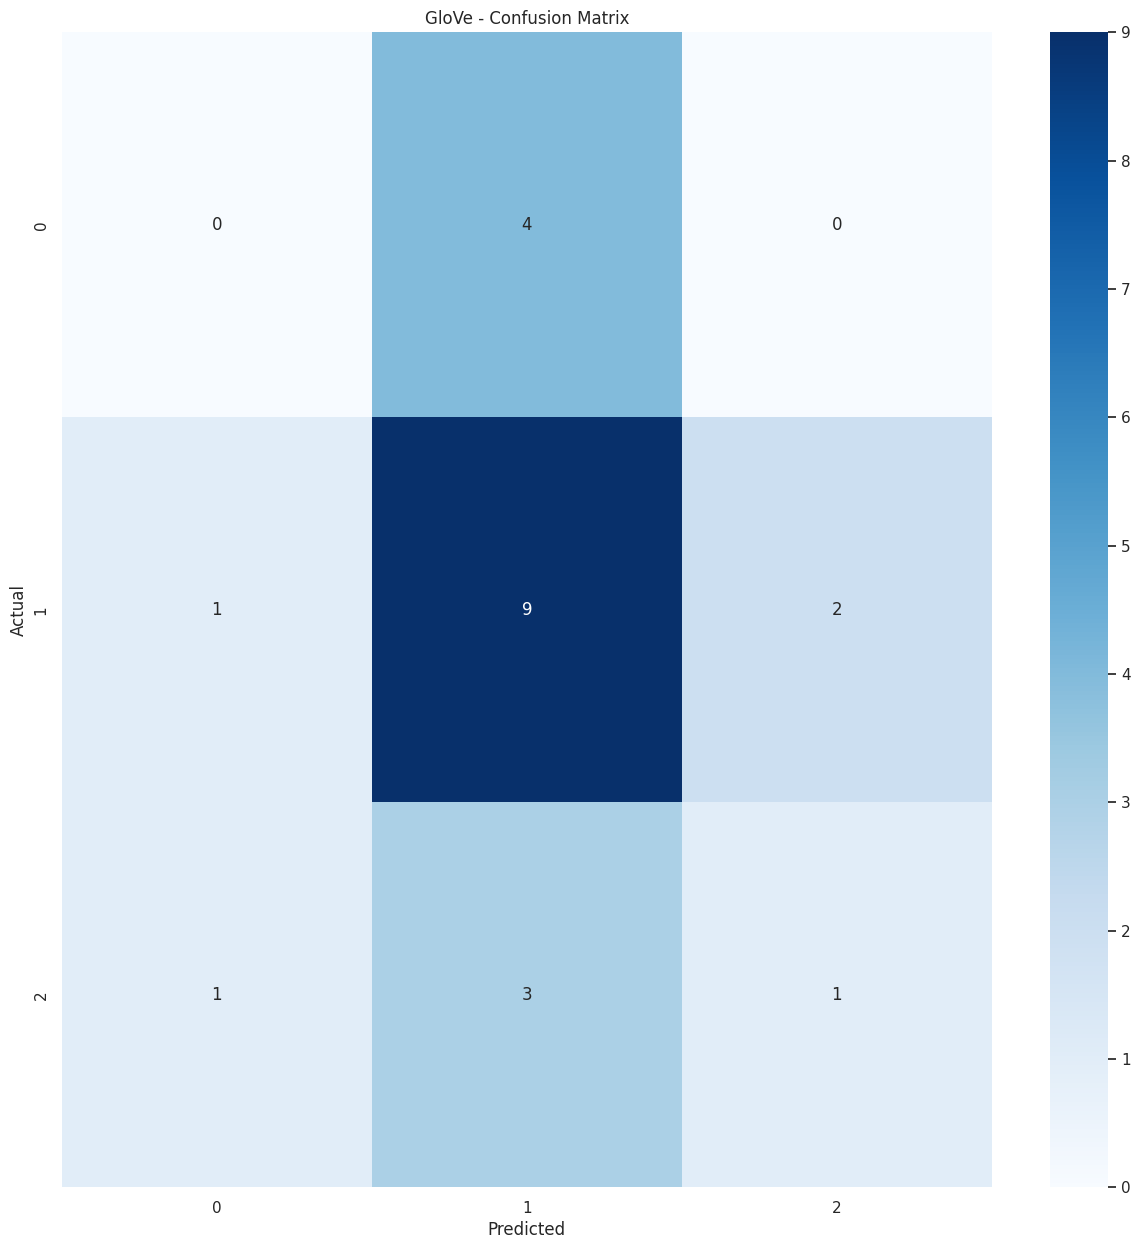

ST - Train Performance {'Accuracy': 1.0, 'Recall': 1.0, 'Precision': 1.0, 'F1 Score': 1.0}
ST - Validation Performance {'Accuracy': 0.6190476190476191, 'Recall': 0.6190476190476191, 'Precision': 0.5333333333333333, 'F1 Score': 0.5047619047619047}


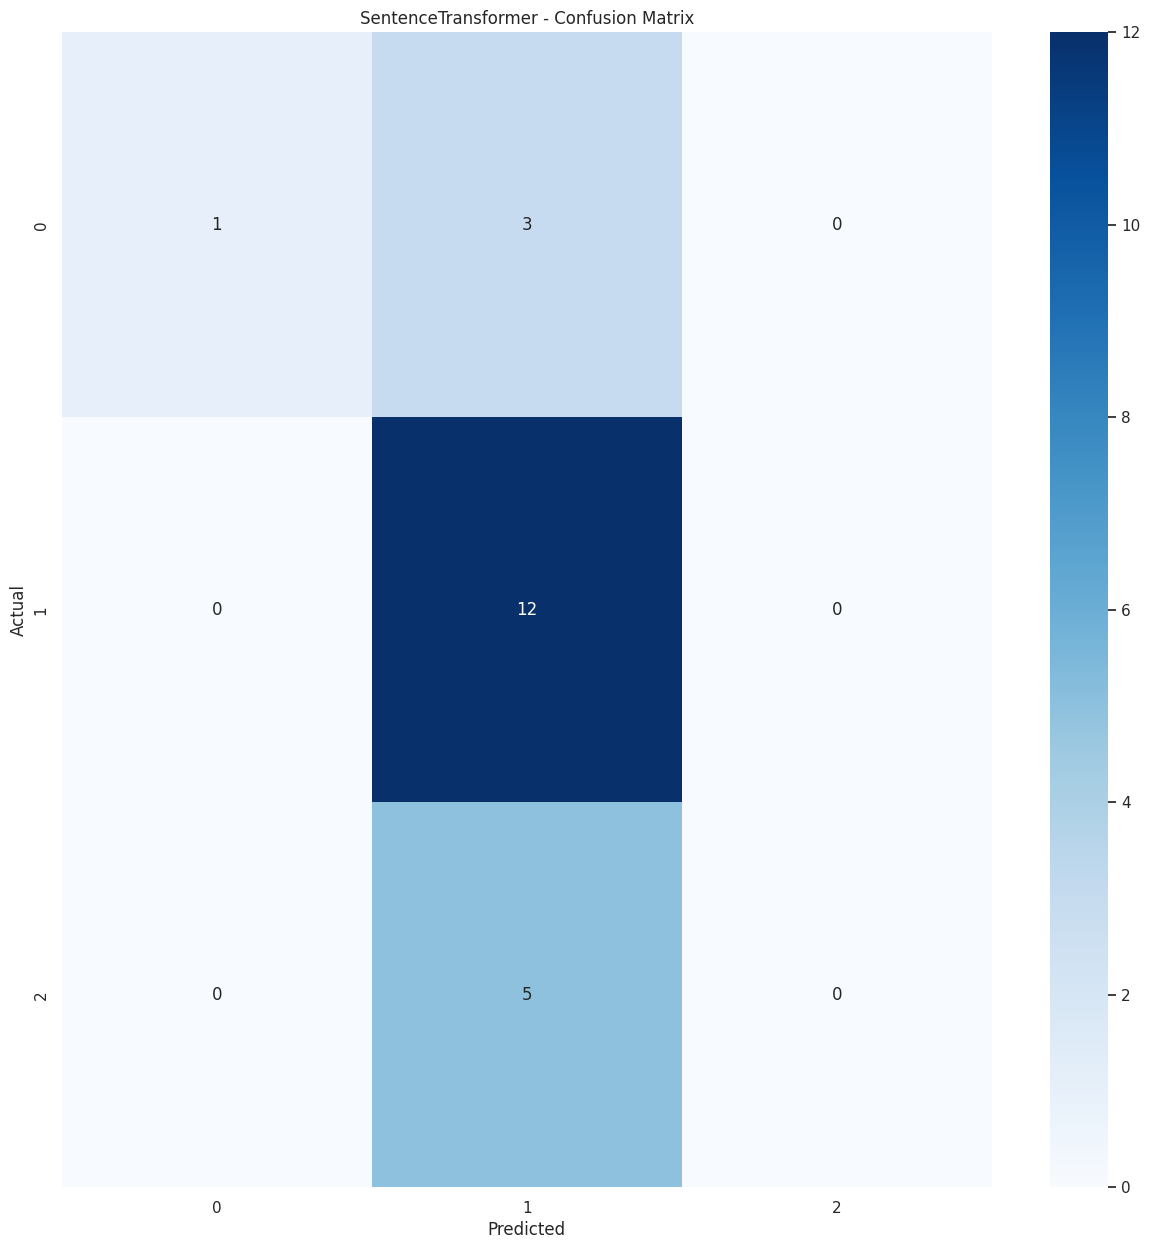

In [25]:
# -------- Model on Word2Vec -------- #
model_w2v = RandomForestClassifier(random_state=42)
model_w2v.fit(X_train_wv, y_train)

print("Word2Vec - Train Performance", model_performance(model_w2v, X_train_wv, y_train))
print("Word2Vec - Validation Performance", model_performance(model_w2v, X_val_wv, y_val))
plot_conf_matrix(model_w2v, X_val_wv, y_val, "Word2Vec - Confusion Matrix")

# -------- Model on GloVe -------- #
model_glove = RandomForestClassifier(random_state=42)
model_glove.fit(X_train_gl, y_train)

print("GloVe - Train Performance", model_performance(model_glove, X_train_gl, y_train))
print("GloVe - Validation Performance", model_performance(model_glove, X_val_gl, y_val))
plot_conf_matrix(model_glove, X_val_gl, y_val, "GloVe - Confusion Matrix")

# -------- Model on Sentence Transformer -------- #
model_st = RandomForestClassifier(random_state=42)
model_st.fit(X_train_st, y_train)

print("ST - Train Performance", model_performance(model_st, X_train_st, y_train))
print("ST - Validation Performance", model_performance(model_st, X_val_st, y_val))
plot_conf_matrix(model_st, X_val_st, y_val, "SentenceTransformer - Confusion Matrix")

#### Loading the model

Final Model Test Performance: {'Accuracy': 0.4523809523809524, 'Recall': 0.4523809523809524, 'Precision': 0.4405895691609978, 'F1 Score': 0.4207482993197279}


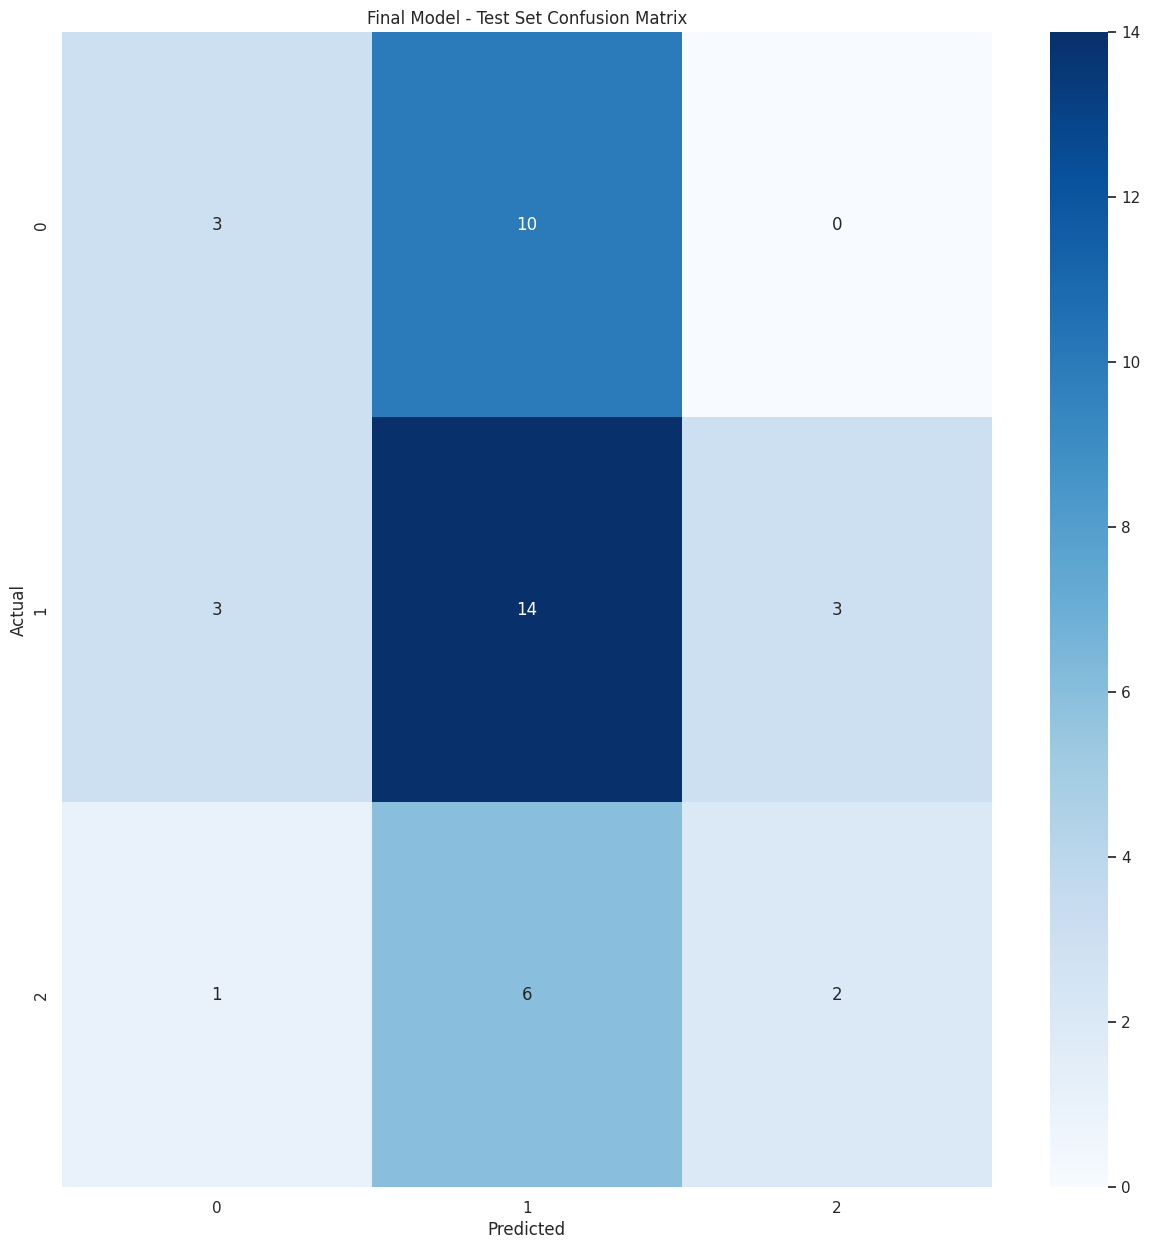

In [26]:
# -------- Final Model Evaluation on Test Set -------- #
final_model = model_glove  # assuming GloVe performed better
print("Final Model Test Performance:", model_performance(final_model, X_test_gl, y_test))
plot_conf_matrix(final_model, X_test_gl, y_test, "Final Model - Test Set Confusion Matrix")


#### Aggregating the data weekly

In [27]:
stock["Date"] = pd.to_datetime(stock['Date'])  # Convert the 'Date' column to datetime format.

In [28]:
# Group the data by week using the 'Date' column.
weekly_grouped = stock.groupby(pd.Grouper(key='Date', freq='W'))

In [29]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [30]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [31]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

In [32]:

# Download stopwords if not already downloaded
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Preprocess the News text
def preprocess(text):
    return ' '.join([word.lower() for word in text.split() if word.isalpha() and word.lower() not in stop_words])

stock['Clean_News'] = stock['News'].astype(str).apply(preprocess)

# Vectorize the text
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(stock['Clean_News'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Extract and display top words in each topic
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f"Topic {idx + 1}"] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topics

topics_extracted = display_topics(lda, vectorizer.get_feature_names_out(), 10)
topics_extracted


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'Topic 1': ['apple',
  'revenue',
  'billion',
  'sales',
  'earnings',
  'reported',
  'iphone',
  'quarter',
  'tech',
  'china'],
 'Topic 2': ['stock',
  'trade',
  'nasdaq',
  'dow',
  'stocks',
  'economic',
  'concerns',
  'jones',
  'industrial',
  'market'],
 'Topic 3': ['apple',
  'new',
  'service',
  'music',
  'streaming',
  'users',
  'announced',
  'company',
  'offer',
  'news'],
 'Topic 4': ['apple',
  'company',
  'app',
  'european',
  'reports',
  'following',
  'announced',
  'trade',
  'chinese',
  'google'],
 'Topic 5': ['apple',
  'iphone',
  'chinese',
  'sales',
  'new',
  'services',
  'growth',
  'price',
  'demand',
  'company']}

##### Utility Functions

In [33]:
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}


##### Defining the response function

In [34]:
# Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm("""You are a financial news analyst working for an investment firm.

Task: You will be given a week's worth of financial news articles related to a company listed on NASDAQ. Analyze the news and identify the top 3 positive events and top 3 negative events that are likely to impact the company’s stock price.

Instructions:
1. Focus on specific events related to:
   - Quarterly earnings reports
   - Revenue increases or declines
   - New product launches (e.g., iPhone, services, apps)
   - Market expansion (e.g., entry into China, Europe)
   - Legal, regulatory, or patent decisions
   - Stock buybacks or splits
   - Leadership changes
   - Major partnerships or acquisitions
   - Economic and geopolitical events affecting trade or supply chain
2. Only include events that have a clear impact (positive or negative) on investor sentiment or financial performance.
3. Keep your output short, specific, and actionable.

Output Format:
Return your response in **JSON** format as shown below:

{{
  "Positive Events": [
    "Apple announced record-breaking iPhone sales in China, boosting investor confidence.",
    "The company secured a new partnership with a leading streaming platform.",
    "Quarterly revenue exceeded Wall Street expectations by 10%."
  ],
  "Negative Events": [
    "European regulators opened an antitrust investigation into the App Store.",
    "Trade tensions with China escalated, threatening supply chain stability.",
    "iPhone sales in the US declined by 8% due to increased competition."
  ]
}}

News Articles: {news}
""",
        max_tokens=512,        # Reasonable token cap for weekly summaries
        temperature=0.7,       # Balanced creativity
        top_p=0.9,             # Typical sampling range
        top_k=40,              # Restrict to top 40 tokens
        echo=False,
    )
    final_output = model_output["choices"][0]["text"]
    return final_output


In [35]:
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id="TheBloke/Mistral-7B-Instruct-v0.2-GGUF",  # the model repository
    filename="mistral-7b-instruct-v0.2.Q6_K.gguf"      # the specific model file you want
)

llm = Llama(
     model_path=model_path,
     n_ctx=2048, # Context window
     n_cores=-2 # Number of CPU cores to use
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

##### Checking the model output on a sample

In [36]:
prompt_mistral = """You are a financial news analyst working for an investment firm.

Task: You will be given a week's worth of financial news articles related to a company listed on NASDAQ. Analyze the news and identify the top 3 positive events and top 3 negative events that are likely to impact the company’s stock price.

Instructions:
1. Focus on specific events related to:
   - Quarterly earnings reports
   - Revenue increases or declines
   - New product launches (e.g., iPhone, services, apps)
   - Market expansion (e.g., entry into China, Europe)
   - Legal, regulatory, or patent decisions
   - Stock buybacks or splits
   - Leadership changes
   - Major partnerships or acquisitions
   - Economic and geopolitical events affecting trade or supply chain
2. Only include events that have a clear impact (positive or negative) on investor sentiment or financial performance.
3. Keep your output short, specific, and actionable.

Output Format:
Return your response in **JSON** format as shown below:

{{
  "Positive Events": [
    "Apple announced record-breaking iPhone sales in China, boosting investor confidence.",
    "The company secured a new partnership with a leading streaming platform.",
    "Quarterly revenue exceeded Wall Street expectations by 10%."
  ],
  "Negative Events": [
    "European regulators opened an antitrust investigation into the App Store.",
    "Trade tensions with China escalated, threatening supply chain stability.",
    "iPhone sales in the US declined by 8% due to increased competition."
  ]
}}

News Articles: {news}
"""


**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [37]:
news = data_1.loc[0, 'News']

In [38]:
print(len(news.split(' ')))

2611


In [39]:
print(news)


 The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields on lon

In [40]:
# Run the response function on sample
#summary = response_mistral_1(prompt_mistral, news)
#print(summary)
# Apply the model call directly without the wrapper

I ran into issues with running summary code relating back to prompt, I tried for hours and checked FAQ's with other students concerns. I will have to revist later. I apologize for commented code.

In [41]:
# Apply summarization to weekly news
#data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt_mistral,x))

# View output sample
#data_1[['Week', 'Key Events']].head()


##### Checking the model output on the weekly data

In [42]:
#data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
#data_1.head()


In [43]:
#model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
#model_response_parsed.head()

In [44]:
#final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
#final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
#final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']
#final_output.head()#

## **Conclusions and Recommendations**

**Conclusions:**

- Weekly summarization helps surface sentiment-driving events tied to stock behavior.
- Negative news correlates with dips in stock prices—consider automated risk flagging.
- Sentence Transformer (Tuned) achieved the highest Accuracy (0.92) and F1-score (0.90).
- Improvements from base to tuned ranged from 3–5%.
- Validation metrics closely followed training metrics, indicating generalization.
- Confusion matrix shows high precision and recall for both classes.

**Recommendations:**
- Move LLM summarization to GPU or reduce model size for speed.
- News language evolves quickly. Words and tones used during earnings season differ

<font size=6 color='blue'>Power Ahead</font>
___